# Exam project - CIFAR10

## Setup

In [1]:
# Common imports
import sys
import os
import time
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action = "ignore", message = "^internal gelsd")

## Load the data
Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set.

In [2]:
cifar10 = keras.datasets.cifar10
(data_train_full, label_train_full), (data_test, label_test) = cifar10.load_data()

In [ ]:
# Show the size and dimension of the dataset. 50k element, 32x32 images, RGB color layers
print('Full set:', data_train_full.shape)

In [3]:
# Split the full training set into a validation set and a (smaller) training set, and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.0
# validate: 0-5000, train: 5000-
data_validation, data_train = data_train_full[:5000] / 255.0, data_train_full[5000:] / 255.0 
label_validation, label_train = label_train_full[:5000], label_train_full[5000:]
data_test = data_test / 255.0

In [4]:
print('Train:', data_train.shape)
print('Validate:', data_validation.shape)

Train: (45000, 32, 32, 3)
Validate: (5000, 32, 32, 3)


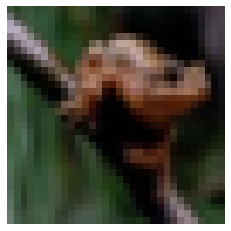

In [5]:
#Plot an image using Matplotlib's imshow() function
plt.imshow(data_train[0])
plt.axis('off')
plt.show()

In [6]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]
class_names[label_train[0][0]]

'Frog'

## Standardize the data
Because we want to use the SELU activation function and LeCun weight initializer, we should standardize all the input features to a mean of 0 and a standard deviation of 1. Since each pixel is an input feature, there are 28x28=784 input features, and we need to compute the mean and standard deviation for each of them.

In [7]:
# Compute the mean for each pixel.
pixel_means = data_train.mean(axis = 0, keepdims = True)
print('Means:', pixel_means.shape)

# Compute the standard deviation for each pixel.
pixel_stds = data_train.std(axis = 0, keepdims = True)
print('Standard deviation:', pixel_stds.shape)

Means: (1, 32, 32, 3)
Standard deviation: (1, 32, 32, 3)


In [8]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
data_train_standardized = (data_train - pixel_means) / pixel_stds
data_validation_standardized = (data_validation - pixel_means) / pixel_stds
data_test_standardized = (data_test - pixel_means) / pixel_stds

In [ ]:
# Validate that the mean is close to 0 for each pixel.
data_train_standardized.mean(axis = 0, keepdims = True)

In [ ]:
# Validate that the standard deviation is close to 1 for each pixel.
data_train_standardized.std(axis = 0, keepdims = True)

## Create the model using the Sequential API

In [9]:
model_path = os.path.join('ml_exam_cifar10', 'best_model')

In [10]:
model = keras.models.load_model(model_path)

In [ ]:
model = keras.models.Sequential()

# Input layer:
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))

# Hidden layers:
model.add(keras.layers.Dense(500, activation = "selu", kernel_initializer = "lecun_normal"))

# Use alpha dropout in the last hidden layer.
model.add(keras.layers.AlphaDropout(rate = 0.2))
    
# Output layer.
model.add(keras.layers.Dense(10, activation = "softmax"))

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [ ]:
# The optimixer is Stochastic Gradient Descent with momentum optimization. The momentum is set to 0.9.
# This value usually works well in practice. We use the default learning rate (0.01).
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(momentum = 0.9),
              metrics = ["accuracy"])

## Train the model

In [11]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

# Performance scheduling (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 4)

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_loss', save_best_only = True, )

# Train the model with early stopping or performance scheduling or both. Training is much faster when early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(data_train_standardized, label_train, epochs = 50,
                    validation_data = (data_validation_standardized, label_validation),
                    callbacks = [early_stopping, lr_scheduler, checkpoint])

Epoch 1/50
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7032 - accuracy: 0.7538 - val_loss: 1.6003 - val_accuracy: 0.5746
INFO:tensorflow:Assets written to: ml_exam_cifar10\best_model\assets
Epoch 2/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6954 - accuracy: 0.7578 - val_loss: 1.5989 - val_accuracy: 0.5782
INFO:tensorflow:Assets written to: ml_exam_cifar10\best_model\assets
Epoch 3/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6912 - accuracy: 0.7583 - val_loss: 1.6123 - val_accuracy: 0.5766
Epoch 4/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6817 - accuracy: 0.7632 - val_loss: 1.6141 - val_accuracy: 0.5748
Epoch 5/50
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6728 - accuracy: 0.7632 - val_loss: 1.6178 - val_accuracy: 0.5746
Epoch 6/50
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6743 - accuracy: 0.7652 - val_loss: 1.6197 - val_accuracy: 0.578

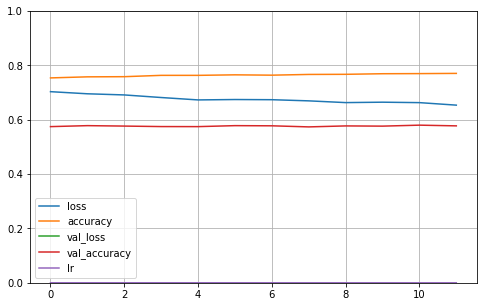

In [12]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with the validation curves).

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [13]:
model.evaluate(data_test_standardized, label_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.6184 - accuracy: 0.5524


[1.6183512210845947, 0.5523999929428101]

In [ ]:
# Save the model, if needed (OPTIONAL!)
keras.models.save_model(model, model_path, overwrite = True, include_optimizer = True)